Phi-hung HOANG et Camille POINGT

# Notebook Compétition 2

Dans ce notebook nous utiliserons un réseau de neuronnes convolutif déjà existant afin de classifer des images de navire.

In [24]:
!ls /kaggle/working

__notebook_source__.ipynb  submission.csv


In [25]:
# imports
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, Resizing, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras import layers, regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

Dans un premier temps, nous avons besoin de charger les images. Pour cela nous utilisons la fonction image_dataset_from_directory de la bibliotèque Tensorflow. Nous en profitons aussi pour séparer les images en deux datasets d'entrainement et de validation.

In [26]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/navires-2023-libre/ships16x24/ships_16x24_10cat/data/', labels="inferred", label_mode="categorical",
  validation_split=0.2,
  subset="training",
  shuffle=True,
  seed=123,
  image_size=(16, 24))

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/kaggle/input/navires-2023-libre/ships16x24/ships_16x24_10cat/data/', labels="inferred", label_mode="categorical",
  validation_split=0.2,
  subset="validation",
  shuffle=True,
  seed=123,
  image_size=(16, 24))


Found 35515 files belonging to 10 classes.
Using 28412 files for training.
Found 35515 files belonging to 10 classes.
Using 7103 files for validation.


# EfficientNet model

Après plusieurs essais avec des réseaux de neuronnes pré-entrainés, nous avons décidé d'utiliser le réseau EfficientNet et plus particulièrement sa 3ème version (B2). EfficientNet est un modèle de réseau neuronal convolutif (CNN) qui utilise une approche d'optimisation conjointe de la profondeur, de la largeur et de la résolution de la convolution pour obtenir des performances élevées avec une efficacité computationnelle accrue.

Nous avons ensuite choisi de former un nouveau réseau en ajoutant à celui existant des couches Dropout et Dense avec l'argument kernel_regularizer afin d'essayer d'éviter l'overfitting.

Par ailleurs nous avons utilisé EarlyStopping de la librairie Tensorflow. Ce dernier est utilisée pour surveiller la précision de validation (val_accuracy) lors de l'entraînement d'un modèle. Si la précision de validation ne s'améliore pas pendant 3 époques consécutives, la formation est arrêtée. De plus, les poids du modèle sont restaurés à ceux qui donnent la meilleure précision de validation obtenue jusqu'à présent

In [27]:
base_model = EfficientNetB2(weights = 'imagenet', include_top= False)

model = Sequential()
model.add(Resizing(224,224,input_shape = (16,24,3)))
model.add(base_model)
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128,activation = LeakyReLU(alpha=0.1), kernel_regularizer = regularizers.l2(0.60)))
model.add(Dense(10,activation = 'softmax'))

model.compile(optimizer=Adadelta(learning_rate=0.0178), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = True)

model_history = model.fit(train_ds, epochs=50, validation_data=val_ds, batch_size = 128, callbacks = [early_stopping])

Epoch 1/50


2023-05-28 11:48:35.871263: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


888/888 [==============================] - 337s 324ms/step - loss: 53.9941 - accuracy: 0.4204 - val_loss: 13.7240 - val_accuracy: 0.5569
Epoch 2/50
888/888 [==============================] - 286s 322ms/step - loss: 6.7813 - accuracy: 0.5881 - val_loss: 3.3399 - val_accuracy: 0.6114
Epoch 3/50
888/888 [==============================] - 285s 321ms/step - loss: 2.3263 - accuracy: 0.6504 - val_loss: 1.8500 - val_accuracy: 0.6251
Epoch 4/50
888/888 [==============================] - 286s 322ms/step - loss: 1.5040 - accuracy: 0.6836 - val_loss: 1.4840 - val_accuracy: 0.6520
Epoch 5/50
888/888 [==============================] - 286s 321ms/step - loss: 1.2570 - accuracy: 0.7129 - val_loss: 1.3658 - val_accuracy: 0.6642
Epoch 6/50
888/888 [==============================] - 285s 321ms/step - loss: 1.1393 - accuracy: 0.7389 - val_loss: 1.3159 - val_accuracy: 0.6683
Epoch 7/50
888/888 [==============================] - 285s 321ms/step - loss: 1.0609 - accuracy: 0.7585 - val_loss: 1.2829 - val_accu

# Précisions sur les datasets d'entrainement et de validation

Après l'entrainement du modèle, nous obtenons les précisions affichées ci-dessous.

In [28]:
train_loss, train_accuracy = model.evaluate(train_ds)
val_loss, val_accuracy = model.evaluate(val_ds)

# Afficher la précision du modèle
print("Précision du modèle sur les données d'entraînement : {:.2f}%".format(train_accuracy * 100))
print("Précision du modèle sur les données de validation : {:.2f}%".format(val_accuracy * 100))

222/222 [==============================] - 12s 55ms/step - loss: 1.2354 - accuracy: 0.7093
Précision du modèle sur les données d'entraînement : 97.26%
Précision du modèle sur les données de validation : 70.93%


# Evolution des précisions sur les datasets d'entrainement et de validation

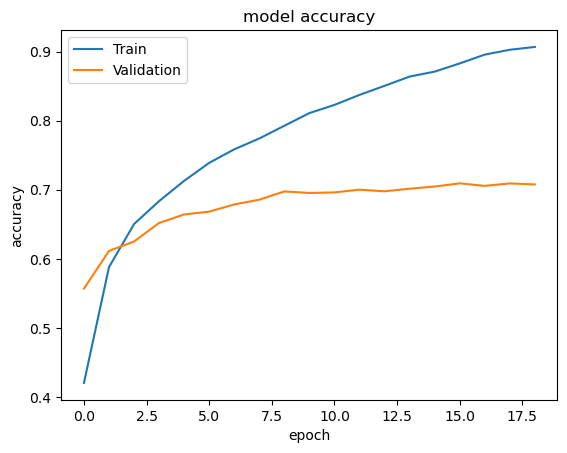

In [29]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

On remarque que la précision sur le dataset d'entrainement tend vers 0.90 là où celle du dataset de validation tend vers 0.70. Cette différence assez important témoigne d'un sur-apprentissage. Ce dernier pourrait être dû à un nombre d'input du réseau trop important ou à un dropout pas assez important.

# Matrice de confusion

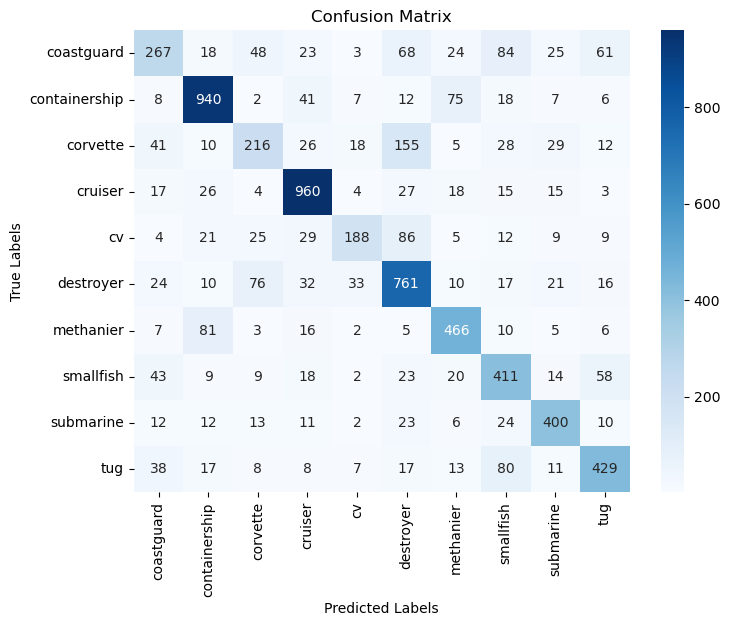

In [30]:
y_true = []
y_pred = []
for x,y in val_ds:
    x_predict = model.predict(x,verbose=0)
    y = tf.argmax(y,axis=1)
    y_true.append(y)
    y_pred.append(tf.argmax(x_predict ,axis = 1))
  
y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

classes = ['coastguard', 'containership', 'corvette', 'cruiser', 'cv', 'destroyer', 'methanier', 'smallfish', 'submarine', 'tug']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Avec la matrice de confusion ci-dessus, on remarque en regardant la diagonale que la plupart des images sont bien prédit. En effet bien que les valeurs hors diagonales soient non nulles, celles de la diagonale restent prédominantes.

# Chargement et prédiction sur le dataset de test

In [31]:
X_test = np.load('/kaggle/input/navires-2023-libre/test.npy', allow_pickle=True)

In [32]:
res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("submission.csv", index_label="Id")

116/116 [==============================] - 8s 48ms/step


In [33]:
!head submission.csv

Id,Category
0,3
1,8
2,2
3,7
4,3
5,0
6,3
7,3
8,5


In [34]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv